In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
from operator import itemgetter
import nxviz as nv

In [2]:
ratings = pd.read_csv('/home/alainkuiete/Documents/DATA612/rating.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [3]:
ratings.userId = [str(n)+'U' for n in ratings.userId]
ratings.movieId = [str(n)+'M' for n in ratings.movieId]

In [4]:
ratings.shape

(20000263, 4)

In [5]:
rating = ratings.iloc[:4000, :]

## Create a bipartite graph

### Add weighted edges between opposite nodes

In [6]:
G = nx.Graph()

In [7]:
edges = rating[['userId', 'movieId', 'rating']]

In [8]:
edgelist = np.array(edges)

In [9]:
G.add_weighted_edges_from(edgelist)

In [10]:
#G = nx.from_pandas_edgelist(rating, 'userId', 'movieId', 'rating')

In [11]:
nx.is_connected(G)

True

In [12]:
#G.edges(data=True)

### Add nodes with node attribute

In [13]:
G.add_nodes_from(set(rating.userId), bipartite = 0)
G.add_nodes_from(set(rating.movieId), bipartite = 1)

In [14]:
print(bipartite.is_bipartite(G))

True


In [15]:
#edglist = [(wiki.node1[wiki.index[n]], wiki.node2[wiki.index[n]]) for n in range(0, len(wiki.index))]

In [16]:
#B.add_edges_from(edglist)

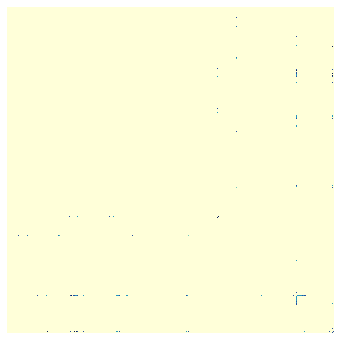

In [17]:
mg = nv.MatrixPlot(G)
mg.draw()
plt.show()

### The two different subgraphs

In [18]:
user, movie = bipartite.sets(G)
print("Number of user nodes: ", len(user))
print("Number of movie nodes: ", len(movie))


Number of user nodes:  35
Number of movie nodes:  1891


In [19]:
user_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
movie_nodes = set(G) - user_nodes

In [20]:
#print(user)

In [21]:
bipartite.density(G, user)

0.060436654831155096

In [22]:
bipartite.density(G, movie)

0.060436654831155096

In [23]:
u = bipartite.projected_graph(G, user)
m = bipartite.projected_graph(G, movie)

In [24]:
#u.edges(data=True)

### Components with more than 5 connections

In [25]:
[len(c) for c in list(u.subgraph(b) for b in nx.connected_components(u)) if len(c) > 5]

[35]

## Island Method for the Bipartite Graph

In [26]:
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f, to, weight = edata)
    return g2

In [27]:
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [28]:
cc=list([G.subgraph(n) for n in nx.connected_components(G)])[0]
islands=island_method(cc)
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0], len(list(i[1])), len(list(G.subgraph(n) for n in nx.connected_components(i[1])))) 

0 1926 1
1 1850 1
2 1736 1
3 1368 1
4 691 1


In [29]:
####  Convert Graph G to a matrix format: A Convert Graph G to a matrix format: A

In [30]:

A = nx.to_numpy_matrix(G)

## Users Network

### Distribution of Degrees Centrality of the Network of Users

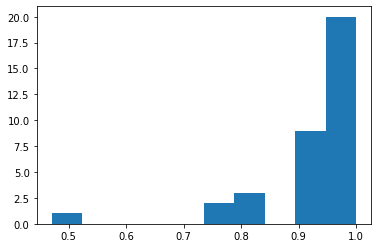

In [31]:
plt.hist(list(nx.degree_centrality(u).values()))
plt.show()

### Nodes with high degree centrality

In [32]:
def nodes_with_highest_deg_cent(h):
    deg_cent = nx.degree_centrality(h)
    max_dc = max(list(deg_cent.values()))
    nodes = set()
    for k,v in deg_cent.items():
        if v == max_dc:
            nodes.add(k)
    return nodes

In [33]:
top_dc = nodes_with_highest_deg_cent(u)

In [34]:
print(top_dc)

{'23U', '32U', '15U', '24U', '22U', '21U', '3U', '1U', '13U', '25U', '34U', '29U', '8U'}


### Distribution of betweenness centrality

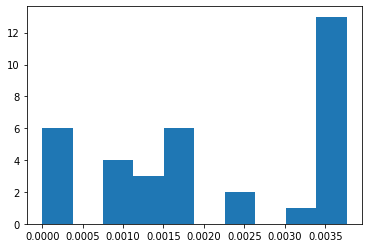

In [35]:
plt.hist(list(nx.betweenness_centrality(u).values()))
plt.show()

### Nodes with hgh betweeness centrality

In [36]:
def nodes_with_highest_bet_cent(h):
    deg_cent = nx.betweenness_centrality(h)
    max_dc = max(list(deg_cent.values()))
    nodes = set()
    for k,v in deg_cent.items():
        if v == max_dc:
            nodes.add(k)
    return nodes

In [37]:
top_bet = nodes_with_highest_bet_cent(u)

In [38]:
print(top_bet)

{'23U', '32U', '15U', '24U', '22U', '21U', '3U', '1U', '13U', '25U', '34U', '29U', '8U'}


### Eigenvector Centrality

In [39]:
eigen_cent = nx.eigenvector_centrality(u)

In [40]:
# Assign each to an attribute in your network
nx.set_node_attributes(u, eigen_cent, 'eigenvector')

In [41]:
sorted_eigenvector = sorted(eigen_cent.items(), key=itemgetter(1), reverse=True)

In [42]:
print("Top 10 nodes by Eigenvector centrality:")
for e in sorted_eigenvector[:10]:
    print(e,  nx.get_node_attributes(u, 'eigenvector')[e[0]])

Top 10 nodes by Eigenvector centrality:
('23U', 0.17843027102602604) 0.17843027102602604
('24U', 0.17843027102602604) 0.17843027102602604
('1U', 0.17843027102602604) 0.17843027102602604
('29U', 0.17843027102602604) 0.17843027102602604
('22U', 0.17843027102602604) 0.17843027102602604
('21U', 0.17843027102602604) 0.17843027102602604
('34U', 0.17843027102602604) 0.17843027102602604
('32U', 0.17843027102602604) 0.17843027102602604
('3U', 0.17843027102602604) 0.17843027102602604
('13U', 0.17843027102602604) 0.17843027102602604


### Users that are totaly connected

In [43]:
largest_clique_u = sorted(nx.find_cliques(u), key=lambda x:len(x))[-1]

In [68]:
glcu = u.subgraph(largest_clique_u)
len(glcu)

29

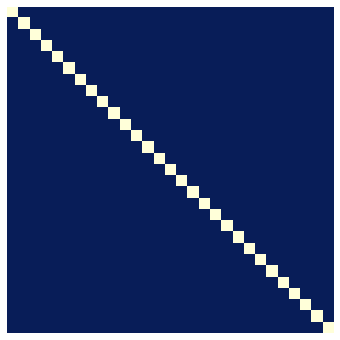

In [69]:
mu = nv.MatrixPlot(glcu)
mu.draw()
plt.show()

In [45]:
[len(c) for c in list(u.subgraph(b) for b in nx.connected_components(u)) if len(c) > 1]

[35]

### visualization with MatrixPlot

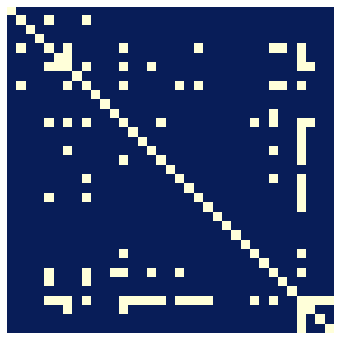

In [46]:
mu = nv.MatrixPlot(u)
mu.draw()
plt.show()

In [47]:
# Convert A back to the NetworkX form as a directed graph: T_conv
T_conv = nx.from_numpy_matrix(A, create_using=nx.DiGraph())

## Movies Network

### Distribution of Degrees Centrality of the Network m

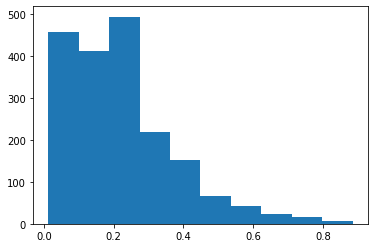

In [48]:
plt.hist(list(nx.degree_centrality(m).values()))
plt.show()

### Nodes with high degree centrality

In [49]:
top_dcm = nodes_with_highest_deg_cent(m)

In [50]:
print(top_dcm)

{'260M'}


### Distribution of betweenness centrality

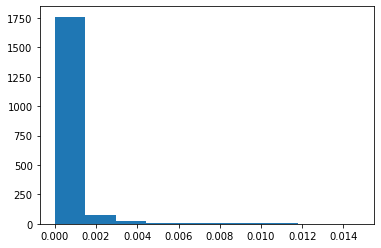

In [51]:
plt.hist(list(nx.betweenness_centrality(m).values()))
plt.show()

### Nodes with hgh betweeness centrality

In [52]:
top_betm = nodes_with_highest_bet_cent(m)

In [53]:
print(top_betm)

{'260M'}


### Eigenvector Centrality

In [54]:
eigen_cent_m = nx.eigenvector_centrality(m)

In [55]:
# Assign each to an attribute in your network
nx.set_node_attributes(m, eigen_cent_m, 'eigenvector')

In [56]:
sorted_eigenvector_m = sorted(eigen_cent_m.items(), key=itemgetter(1), reverse=True)

In [57]:
print("Top 10 nodes by Eigenvector centrality:")
for e in sorted_eigenvector_m[:10]:
    print(e,  nx.get_node_attributes(m, 'eigenvector')[e[0]])

Top 10 nodes by Eigenvector centrality:
('260M', 0.05560070212173587) 0.05560070212173587
('1196M', 0.05537921681845033) 0.05537921681845033
('1270M', 0.05478022677382629) 0.05478022677382629
('1210M', 0.05477557114293356) 0.05477557114293356
('4306M', 0.054483311297852666) 0.054483311297852666
('480M', 0.054018505282531035) 0.054018505282531035
('589M', 0.053481858376522466) 0.053481858376522466
('356M', 0.05324583952723292) 0.05324583952723292
('316M', 0.05310014893325713) 0.05310014893325713
('1M', 0.05274894292646176) 0.05274894292646176


In [58]:
largest_clique_m = sorted(nx.find_cliques(m), key=lambda x:len(x))[-1]

In [67]:
glcm = m.subgraph(largest_clique_m)
len(list(glcm))

506

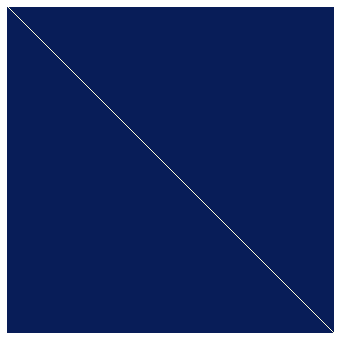

In [65]:
mm = nv.MatrixPlot(glcm)
mm.draw()
plt.show()

### Visualization with MatrixPlot

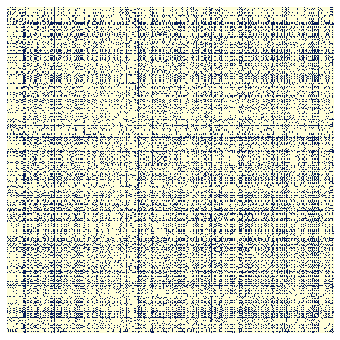

In [60]:
mm = nv.MatrixPlot(m)
mm.draw()
plt.show()